In [ ]:
"""Загрузка библиотек и данных проекта"""

import os
import cv2
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!git clone https://github.com/Laz-eg/Sick-chicken-detection.git

!gdown 1OrjBoYtF_OEh_vVOQJuUtBPlcMxIDJeZ
!gdown 1kHJ-TP67KraQYFkKi7IT4fK7LZoqlFVY

Cloning into 'Sick-chicken-detection'...
remote: Enumerating objects: 3186, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 3186 (delta 0), reused 19 (delta 0), pack-reused 3167
Receiving objects: 100% (3186/3186), 181.82 MiB | 15.28 MiB/s, done.
Downloading...
From (original): https://drive.google.com/uc?id=1OrjBoYtF_OEh_vVOQJuUtBPlcMxIDJeZ
From (redirected): https://drive.google.com/uc?id=1OrjBoYtF_OEh_vVOQJuUtBPlcMxIDJeZ&confirm=t&uuid=65418868-f669-477a-be80-0342978ae6ba
To: /content/classifier_84.h5
100% 1.61G/1.61G [00:08<00:00, 187MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kHJ-TP67KraQYFkKi7IT4fK7LZoqlFVY
From (redirected): https://drive.google.com/uc?id=1kHJ-TP67KraQYFkKi7IT4fK7LZoqlFVY&confirm=t&uuid=f6d9c702-39d8-453b-9c61-2f2601e14f44
To: /content/detector_98.h5
100% 1.55G/1.55G [00:43<00:00, 35.8MB/s]


In [ ]:
"""Загружаем детектор и классификатор"""

detector = keras.models.load_model('/content/detector_98.h5')
classifier = keras.models.load_model('/content/classifier_84.h5')

In [ ]:
"""Проверку совместной работы детектора и классификатора произведем на
валидационных данных датасета sick chickens"""
"""Загрузим аннотации"""

folder_path = '/content/Sick-chicken-detection/data/sick chickens/valid/'

annot = pd.read_csv(folder_path+'_annotations.csv', names=['filename','x1','y1','x2','y2','class'])
annot.head()

,filename,x1,y1,x2,y2,class
0,images-2024-02-08T152201-959_jpeg.rf.1d5e0e300...,80,71,637,637,sickChicken
1,images-2024-02-08T152507-293_jpeg.rf.2310ed46f...,28,155,601,513,sickChicken
2,chickens_chicken_rest_poultry_jpg.rf.00f766204...,47,76,254,584,healthyChicken
3,chickens_chicken_rest_poultry_jpg.rf.00f766204...,222,260,499,531,healthyChicken
4,chicken_hen_feathers_cock_jpg.rf.36f4094368d2d...,217,73,395,611,healthyChicken


In [ ]:
"""Полезные функции"""

# Функция для расчета IoU (Intersection over Union)
def compute_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area

# Функция для автосегментации изображений
def selective_search(image):
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects


sickChicken
2/2 [==============================] - 5s 5s/step


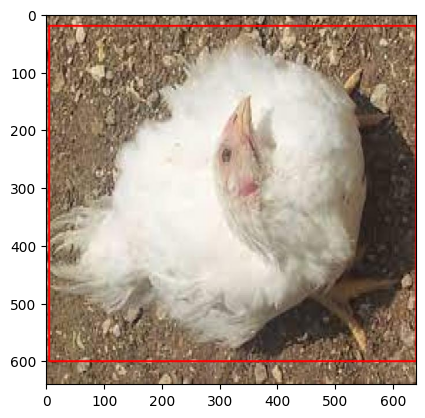

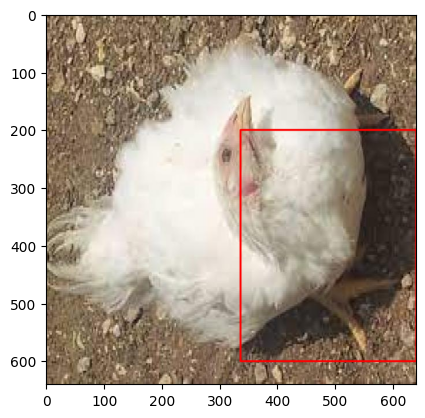

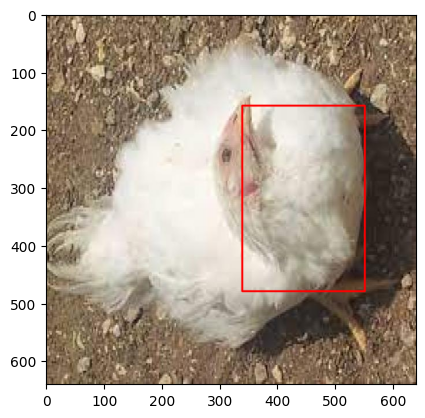

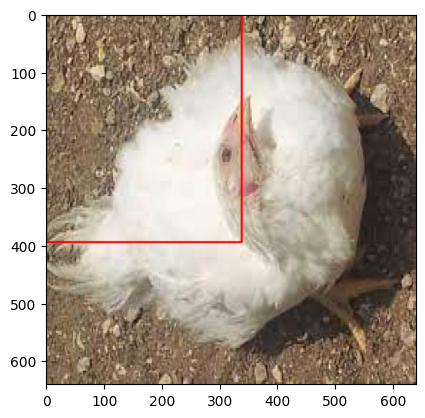

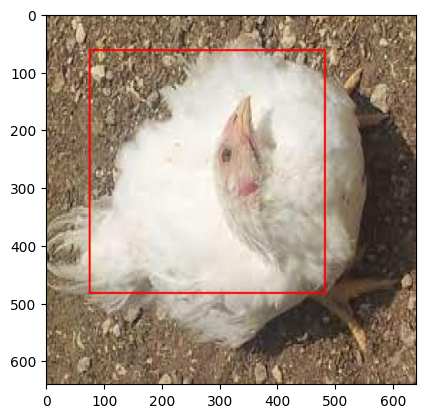

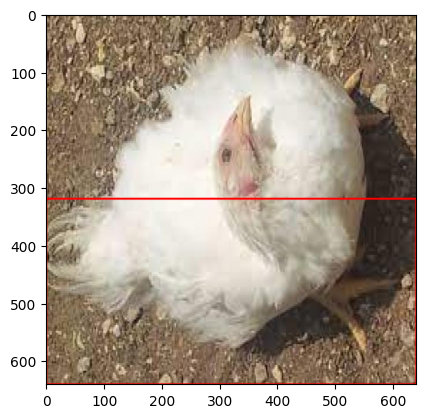

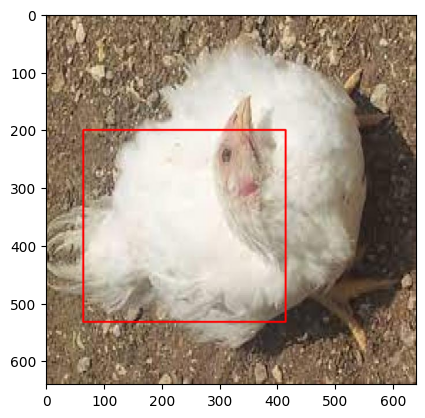

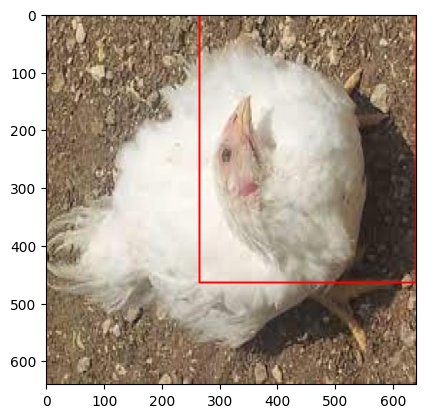

In [ ]:
"""Подробный анализ одного изображения, обработанного нейросетями"""

annot_entry = 5
detection_threshold = 0.9
# Сегментация и получение прямоугольников
filename, x1, y1, x2, y2, mark = annot.iloc[annot_entry]
img = cv2.imread(folder_path+filename)
rects = selective_search(img)
print(mark)

chicken_imgs = [] # вырезанные из фотографии прямоугольники и переформатированнные

for rect in rects: # вырезаем прямоугольники
  x, y, w, h = rect
  chicken_img = img[y:y+h, x:x+w]
  img_resized = cv2.resize(chicken_img, (224, 224))
  chicken_imgs.append(img_resized)
# детектируем куриц
chicken_imgs = np.array(chicken_imgs)
prob_detect = detector.predict(chicken_imgs)
ind = []
# определяем прямоугольники, в которых задетектированы курицы
while len(ind) == 0:
  for i in range(prob_detect.shape[0]):
    if prob_detect[i][0] > detection_threshold:
      ind.append(i)
  detection_threshold -= 0.1
  if detection_threshold < 0.5:
    break
# определяем больные ли курицы задетектированы
prob_sick = classifier.predict(chicken_imgs[ind])
used = []
# отмечаем и выделяем куриц, без сильно перекрывающихся участков картинки
for i in range(prob_sick.shape[0]):
  img2 = np.copy(img)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  flag = False
  if i > 0: # цикл, проверяющий перекрытия
    for j in used:
      if compute_iou(rects[ind[j]], rects[ind[i]]) > 0.5:
        flag = True
        break
  if flag:
    continue
  # рисуем
  x, y, w, h = rects[ind[i]]
  if prob_sick[i][1] > 0.7:
    cv2.rectangle(img2, (x, y), (x + w, y + h), (255, 0, 0), 2, cv2.LINE_AA) # красные -- больные
  else:
    cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2, cv2.LINE_AA) # зеленые -- здоровые
  plt.imshow(img2)
  plt.show()
  used.append(i)

In [ ]:
"""Убираем повторение файлов из нотации (повторяющиеся строки имеют одинаковый класс)"""
annot_prep = annot.drop_duplicates(subset=['filename'], keep='first')
annot_prep.set_index(np.arange(len(annot_prep)))
annot_prep.head()

,filename,x1,y1,x2,y2,class
0,images-2024-02-08T152201-959_jpeg.rf.1d5e0e300...,80,71,637,637,sickChicken
1,images-2024-02-08T152507-293_jpeg.rf.2310ed46f...,28,155,601,513,sickChicken
2,chickens_chicken_rest_poultry_jpg.rf.00f766204...,47,76,254,584,healthyChicken
4,chicken_hen_feathers_cock_jpg.rf.36f4094368d2d...,217,73,395,611,healthyChicken
5,images-2024-02-08T152647-850_jpeg.rf.1021bada9...,64,34,561,574,sickChicken


In [ ]:
"""Детектор больных куриц (полная модель)"""

def sickness_detector(img, detection_threshold=0.9, sickness_threshold=0.5, fraction=0.5):
    """Получает на вход картинку, если на нем есть больная курица,
    то возвращает 1, иначе 0."""

    rects = selective_search(img) # сегментация фотографии
    chicken_imgs = [] # вырезанные из фотографии прямоугольники и переформатированнные
    for rect in rects: # вырезаем прямоугольники
      x, y, w, h = rect
      chicken_img = img[y:y+h, x:x+w]
      img_resized = cv2.resize(chicken_img, (224, 224))
      chicken_imgs.append(img_resized)
    # детектируем куриц
    chicken_imgs = np.array(chicken_imgs)
    prob_detect = detector.predict(chicken_imgs) # применяем детектор
    ind = []
    # определяем прямоугольники, в которых задетектированы курицы
    while len(ind) == 0:
      for i in range(prob_detect.shape[0]):
        if prob_detect[i][0] > detection_threshold:
          ind.append(i)
      detection_threshold -= 0.1
      if detection_threshold < 0.5:
        print('There is no chicken')
        return -1
    # определяем больные ли курицы задетектированы
    prob_sick = classifier.predict(chicken_imgs[ind]) # применяем классификатор
    marks = []
    # выбираем, на каких прямоугольниках распозналась больная и на каких нет
    for i in range(prob_sick.shape[0]):
      if prob_sick[i][1] > sickness_threshold:
        marks.append(1)
      else:
        marks.append(0)
    marks = np.array(marks)
    if marks.mean() > fraction:
      return 1
    else:
      return 0

In [ ]:
"""Оценка модели по количеству определенных больных куриц"""
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

y_predict = []
y_test = [1 if annot_prep.iloc[c][5] == 'sickChicken' else 0 for c in range(len(annot_prep))]

for image_num in range(len(annot_prep)):
    filename, x1, y1, x2, y2, mark = annot.iloc[image_num]
    img = cv2.imread(folder_path+filename)
    y_predict.append(sickness_detector(img))

y_predict = np.array(y_predict)
y_test = np.array(y_test)

bad_i = []
for i in range(len(y_predict)):
  if y_predict[i] == -1:
    bad_i.append(i)

bad_i = np.array(bad_i)
for i in bad_i[::-1]:
  y_predict = np.delete(y_predict, i)
  y_test = np.delete(y_test, i)

no_chicken = len(bad_i)

accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
matrix = confusion_matrix(y_test, y_predict)

print(f"accuracy = {accuracy}")
print(f"precision = {precision}")
print(f"recall = {recall}")
print('')
print('confusion matrix:')
display(matrix)
print('')
print(f'number of images where is no chickens according to detector: {no_chicken}')

66/66 [==============================] - 13s 194ms/step
There is no chicken
2/2 [==============================] - 0s 197ms/step
accuracy = 0.5714285714285714
precision = 0.6363636363636364
recall = 0.5833333333333334

confusion matrix:


array([[10,  8],
       [10, 14]])


number of images where is no chickens according to detector: 1
